In [3]:
import torch
import torch.nn as nn
from PIL import Image
import numpy as np
import json
import requests
import matplotlib.pyplot as plt
import warnings
import os
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms, models
import kagglehub

warnings.filterwarnings('ignore')
%matplotlib inline
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")

class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding='same', bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.conv3 = nn.Conv2d(out_channels, out_channels * self.expansion, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(out_channels * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

In [4]:
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes):
        super(ResNet, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # Create layers
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if stride != 1 or self.in_channels != out_channels * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels * block.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * block.expansion),
            )

        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.in_channels, out_channels))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

# Function to create ResNet-101
def resnet101(num_classes):
    return ResNet(Bottleneck, [3, 4, 23, 3], num_classes)

# Example of creating a ResNet-101 model
model = resnet101(num_classes=62*6).eval().to(device)
# register_hooks(model)
# print(model)

In [5]:
image_dir = kagglehub.dataset_download("ethan404/captcha6digits")
print("Path to dataset files:", image_dir)

!nvidia-smi

device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

100%|██████████| 27.3M/27.3M [00:00<00:00, 76.1MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/ethan404/captcha6digits/versions/1
Fri Nov  1 15:05:17 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   49C    P0              28W /  70W |    275MiB / 15360MiB |      0%      Default |
|                                         |                      |  

In [6]:
## Import the dataset containing the captcha images

def char_to_index(char):
    if 'a' <= char <= 'z':
        return ord(char) - ord('a')
    elif 'A' <= char <= 'Z':
        return ord(char) - ord('A') + 26
    elif '0' <= char <= '9':
        return ord(char) - ord('0') + 52
    else:
        raise ValueError(f"Invalid character in label: {char}")

def index_to_char(index):
    if index > 52:
        return chr(index - 52 + ord('0'))
    elif index > 26:
        return chr(index - 26 + ord('A'))
    elif index >= 0:
        return chr(index + ord('a'))
    else:
        raise ValueError(f"Invalid index in label: {index}")

class CaptchaDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.image_files = [f for f in os.listdir(image_dir) if (f.index(".jpg") > 0 or f.index (".png") > 0)]
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        # Get image path and label (from filename)
        img_name = self.image_files[idx]
        img_path = os.path.join(self.image_dir, img_name)
        label = img_name.split('_')[0]  # Filename before '.png' is the label

        # Load image
        image = Image.open(img_path).convert('RGB')

        # Apply transformations
        if self.transform:
            image = self.transform(image)

        # Convert label to a tensor of character indices
        label_tensor = torch.tensor([char_to_index(char) for char in label], dtype=torch.long)

        return image, label_tensor

In [7]:
# Check if the directory exists
if not os.path.exists(image_dir):
    raise FileNotFoundError(f"The directory '{image_dir}' does not exist.")

# Define transformations

transform = transforms.Compose([
    # transforms.Resize((224, 224)),  # Resize images to fit ResNet input
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Standard normalization
])


# Initialize dataset and dataloaders
dataset = CaptchaDataset(image_dir=image_dir, transform=transform)

# Split into train and test sets
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)


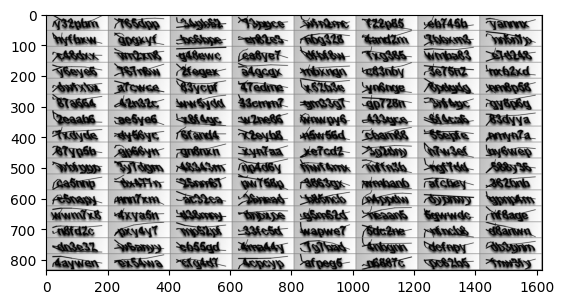

Labels: ['y32pbm', '765dpp', '34gb52', '73pgce', 'wfn2mc', 'f22p85', 'eb745b', 'yannnx', 'nyfbxw', 'gpgxyf', 'bc6bpe', 'en82e3', 'nbg328', '4and2m', '7bbxm3', 'nn5n7p', 'c48dxx', 'wn2xn8', 'g48ewc', 'ca8ye7', 'dfbf8w', 'fxg385', 'wmba83', 'e7d248', 'y6eye6', '767n6w', '2fegex', 'a4gcgx', 'mbxngn', 'c83nby', '3e75n2', 'nxb2xd', 'dwfxbx', 'a7cwce', '83ycpf', '47edme', 'x52b3e', 'yn6nge', '8pdgdg', 'nm8p58', '87a664', '42n32c', 'ww5ydd', '33cmm7', 'gm33g7', 'gp728n', '3nf4gc', 'gy8p6g', '2eaab6', 'ae5ye6', 'x8f4gc', 'w2ne86', 'wnwpy6', '433gce', '6f4ca6', '83dyya', '7xdyde', 'dy56yc', '6fand4', 'x2eyb8', 'n5w56d', 'cbam88', '55epfe', 'nmyn7a', '67yp5b', 'gp66yn', 'gn8nxn', 'xyn7aa', 'xe7cd2', '3g2dny', 'n7w3ef', 'ny6wep', 'wbfggp', '3y7dgm', '48343m', 'np4d6y', 'mwf4mx', 'mffn3b', 'ngf7dd', '588y36', 'ca5nnp', 'dx477n', '25nm67', 'pw758p', '3863gx', 'wmbanb', 'afcbey', '362bnb', 'c5napy', 'nnn7xm', 'ac32ca', '26nead', 'b85ncb', 'n4ppdw', 'dypnwy', 'gpnp4m', 'wwm7x8', '4xya5n', 'd38mny', '

In [8]:
# Helper function to display an image
def imshow(img):
    img = img / 2 + 0.5  # Unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Display a batch of images with labels
dataiter = iter(train_loader)
images, labels = next(dataiter)

num_classes = 62
num_characters = 6  # Assuming each CAPTCHA has 5 characters

# Show images
imshow(torchvision.utils.make_grid(images))

# Print labels (Convert tensor labels to strings for display)
label_strs = [''.join([index_to_char(c) for c in label]) for label in labels]
print('Labels:', label_strs)

In [19]:
from functools import partial

def count_parameters(model):
  """Counts the number of parameters in a PyTorch model."""
  total_params = 0
  for name, module in model.named_modules():
    if isinstance(module, (torch.nn.Linear, torch.nn.Conv2d)):
      print(f"Module: {name} ({type(module).__name__})")
      weight_count = module.weight.numel()
      print(f"  Weight size: {weight_count}")
      if module.bias is not None:
        bias_count = module.bias.numel()
        print(f"  Bias size: {bias_count}")
      else:
        bias_count = 0
      total_params += weight_count + bias_count
  print(f"\nTotal number of parameters: {total_params}, which is {total_params / 1e6:.2f} million. Taking up {total_params * 4 / 1e6:.2f} MB of memory at single precision.")

activation_stats = {}


def hook_fn(module, input, output, layer_name):
    """Hook function to accumulate activation statistics for a unique layer."""
    num_channels = output.shape[1]  # Number of channels in the output

    # Initialize or reinitialize storage for the layer if size mismatch occurs
    if layer_name not in activation_stats or activation_stats[layer_name].size(0) != num_channels:
        activation_stats[layer_name] = torch.zeros(num_channels, device="cpu")  # Move to CPU to save GPU memory

    print(f"Hook triggered for layer: {layer_name} ({type(module).__name__})")

    # Accumulate the mean of absolute activations for each channel
    if output.dim() == 4:  # Conv2d layer output (batch, channels, height, width)
        activation_stats[layer_name] += output.abs().mean(dim=(0, 2, 3)).cpu()
    elif output.dim() == 2:  # Linear layer output (batch, features)
        activation_stats[layer_name] += output.abs().mean(dim=0).cpu()
    else:
        print(f"Unexpected output dimension for layer {layer_name}: {output.dim()}")

def register_hooks(model):
    """Registers hooks on each Conv2d and Linear layer to collect activation statistics."""
    for name, module in model.named_modules():
        if isinstance(module, (torch.nn.Conv2d, torch.nn.Linear)):
            # Use partial to bind the layer name to the hook function
            hook_with_name = partial(hook_fn, layer_name=name)
            module.register_forward_hook(hook_with_name)
            # print(f"Hook registered for layer: {name} ({type(module).__name__})")



In [10]:
# Load  our ResNet-101 model
num_classes = 62
num_characters = 6
model = resnet101(num_classes*num_characters)

In [11]:
# Move the model to GPU
model = model.to(device)

loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1)

num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:

        # imshow(torchvision.utils.make_grid(images))

        # Print labels (Convert tensor labels to strings for display)
        label_strs = [''.join([index_to_char(c) for c in label]) for label in labels]
        # print('Label Strings:', label_strs)

        # Move images and labels to GPU
        images, labels = images.to(device), labels.to(device)
        # print("images.shape",images.shape)
        # print("labels.shape",labels.shape)

        assert labels.max().item() < num_classes, f"Label values exceed num_classes ({num_classes})"

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward
        outputs = model(images)
        # print("model output", outputs.shape)

        outputs = outputs.view(-1, num_characters, num_classes)  # Shape: [batch_size, num_characters, num_classes]

        # labels = labels.view(-1, num_characters) ---  not needed as labels is already in this dimension

        loss = sum(loss_function(outputs[:, i, :], labels[:, i]) for i in range(num_characters)) / num_characters

        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")
    scheduler.step(running_loss)

Epoch [1/10], Loss: 3.0442
Epoch [2/10], Loss: 2.5760
Epoch [3/10], Loss: 1.8337
Epoch [4/10], Loss: 1.0087
Epoch [5/10], Loss: 0.3940
Epoch [6/10], Loss: 0.1441
Epoch [7/10], Loss: 0.0355
Epoch [8/10], Loss: 0.0143
Epoch [9/10], Loss: 0.0119
Epoch [10/10], Loss: 0.0175


In [13]:
# torch.save(model, "model.pth")
model = torch.load("/content/model.pth")

In [13]:
# Set the model to evaluation mode
model.eval()

correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:

        images, labels = images.to(device), labels.to(device)

        outputs = model(images)  # Shape: [batch_size, num_characters * num_classes]

        # Reshape outputs to match number of characters and classes per character
        outputs = outputs.view(-1, num_characters, num_classes)  # Shape: [batch_size, num_characters, num_classes]

        # Taking softmax to convert output to class probabilities
        outputs = torch.softmax(outputs, dim=2)

        # Get predicted characters for each position in the CAPTCHA
        _, predicted = torch.max(outputs, 2)  # Shape: [batch_size, num_characters]

        matches = (predicted == labels).all(dim=1)  # Check if all characters match for each sample
        correct += matches.sum().item()  # Count correct samples
        total += labels.size(0)  # Total number of samples

# Calculate accuracy
accuracy = 100 * correct / total
print(f"Test Accuracy: {accuracy:.2f}%")

Test Accuracy: 93.30%


In [20]:
register_hooks(model)

# Collect activation data across the entire training set without gradients
for images, _ in train_loader:
    images = images.to(device)
    with torch.no_grad():
        model(images)

Streaming output truncated to the last 5000 lines.
Hook triggered for layer: fc (Conv2d)
Hook triggered for layer: layer2.0.conv3 (Conv2d)
Hook triggered for layer: fc (Conv2d)
Hook triggered for layer: fc (Conv2d)
Hook triggered for layer: layer2.0.downsample.0 (Conv2d)
Hook triggered for layer: fc (Conv2d)
Hook triggered for layer: fc (Conv2d)
Hook triggered for layer: layer2.1.conv1 (Conv2d)
Hook triggered for layer: fc (Conv2d)
Hook triggered for layer: fc (Conv2d)
Hook triggered for layer: layer2.1.conv2 (Conv2d)
Hook triggered for layer: fc (Conv2d)
Hook triggered for layer: fc (Conv2d)
Hook triggered for layer: layer2.1.conv3 (Conv2d)
Hook triggered for layer: fc (Conv2d)
Hook triggered for layer: fc (Conv2d)
Hook triggered for layer: layer2.2.conv1 (Conv2d)
Hook triggered for layer: fc (Conv2d)
Hook triggered for layer: fc (Conv2d)
Hook triggered for layer: layer2.2.conv2 (Conv2d)
Hook triggered for layer: fc (Conv2d)
Hook triggered for layer: fc (Conv2d)
Hook triggered for lay

In [21]:
print("\nActivation stats keys after forward pass:")
for key in activation_stats.keys():
    print(key)


Activation stats keys after forward pass:
fc
conv1
layer1.0.conv1
layer1.0.conv2
layer1.0.conv3
layer1.0.downsample.0
layer1.1.conv1
layer1.1.conv2
layer1.1.conv3
layer1.2.conv1
layer1.2.conv2
layer1.2.conv3
layer2.0.conv1
layer2.0.conv2
layer2.0.conv3
layer2.0.downsample.0
layer2.1.conv1
layer2.1.conv2
layer2.1.conv3
layer2.2.conv1
layer2.2.conv2
layer2.2.conv3
layer2.3.conv1
layer2.3.conv2
layer2.3.conv3
layer3.0.conv1
layer3.0.conv2
layer3.0.conv3
layer3.0.downsample.0
layer3.1.conv1
layer3.1.conv2
layer3.1.conv3
layer3.2.conv1
layer3.2.conv2
layer3.2.conv3
layer3.3.conv1
layer3.3.conv2
layer3.3.conv3
layer3.4.conv1
layer3.4.conv2
layer3.4.conv3
layer3.5.conv1
layer3.5.conv2
layer3.5.conv3
layer3.6.conv1
layer3.6.conv2
layer3.6.conv3
layer3.7.conv1
layer3.7.conv2
layer3.7.conv3
layer3.8.conv1
layer3.8.conv2
layer3.8.conv3
layer3.9.conv1
layer3.9.conv2
layer3.9.conv3
layer3.10.conv1
layer3.10.conv2
layer3.10.conv3
layer3.11.conv1
layer3.11.conv2
layer3.11.conv3
layer3.12.conv1
layer

In [26]:
layer_avg_activations = {}

# Calculate average activation for each layer, accounting for batch count
for layer_name, activations in activation_stats.items():
    avg_activation_per_channel = activations / len(train_loader)  # Normalize by the number of batches
    overall_avg_activation = avg_activation_per_channel.mean().item()  # Average across all channels
    layer_avg_activations[layer_name] = overall_avg_activation
    print(f"Layer: {layer_name}, Average Activation per Channel: {overall_avg_activation:.4f}")

# Identify low-activation layers using a threshold
low_activation_threshold = 0.1
low_activation_layers = [name for name, avg_act in layer_avg_activations.items() if avg_act < low_activation_threshold]

print("\nLayers with low activations:")
for layer in low_activation_layers:
    print(layer)

Layer: fc, Average Activation per Channel: 0.8314
Layer: conv1, Average Activation per Channel: 0.5096
Layer: layer1.0.conv1, Average Activation per Channel: 0.5071
Layer: layer1.0.conv2, Average Activation per Channel: 0.5388
Layer: layer1.0.conv3, Average Activation per Channel: 0.3239
Layer: layer1.0.downsample.0, Average Activation per Channel: 0.4940
Layer: layer1.1.conv1, Average Activation per Channel: 0.6079
Layer: layer1.1.conv2, Average Activation per Channel: 0.4819
Layer: layer1.1.conv3, Average Activation per Channel: 0.3237
Layer: layer1.2.conv1, Average Activation per Channel: 0.7207
Layer: layer1.2.conv2, Average Activation per Channel: 0.4827
Layer: layer1.2.conv3, Average Activation per Channel: 0.3310
Layer: layer2.0.conv1, Average Activation per Channel: 0.7966
Layer: layer2.0.conv2, Average Activation per Channel: 0.5738
Layer: layer2.0.conv3, Average Activation per Channel: 0.3280
Layer: layer2.0.downsample.0, Average Activation per Channel: 0.8080
Layer: layer2.1

another approach to selecting a meaningful threshold based on the observed activation distribution. (Something we can add to the report as well)

1. Using a Percentile-Based Threshold
Instead of setting an arbitrary value like 0.1, we can use a percentile-based threshold. For example, flag the bottom 10% or 20% of layers by their average activation:

2. Visualize Activation Distribution
To further understand the distribution of activations, plot a histogram of average activations across layers. This will help us visually identify a reasonable cutoff point:

3. Adjust Based on Empirical Analysis
If model’s performance allows, we could experiment with different thresholds (like the 10th, 15th, or 20th percentiles) and test the pruned model to see the impact on performance.

Using these techniques will provide a data-driven approach to selecting an activation threshold that makes sense for our model


Calculated threshold for low activations (20th percentile): 0.4279

Layers with low activations:
layer1.0.conv3
layer1.1.conv3
layer1.2.conv3
layer2.0.conv3
layer2.1.conv3
layer2.2.conv3
layer2.3.conv3
layer3.0.conv3
layer3.1.conv3
layer3.2.conv3
layer3.3.conv3
layer3.4.conv3
layer3.5.conv3
layer3.6.conv3
layer3.8.conv3
layer3.9.conv3
layer3.10.conv3
layer3.13.conv3
layer3.14.conv3
layer3.15.conv3
layer3.16.conv3


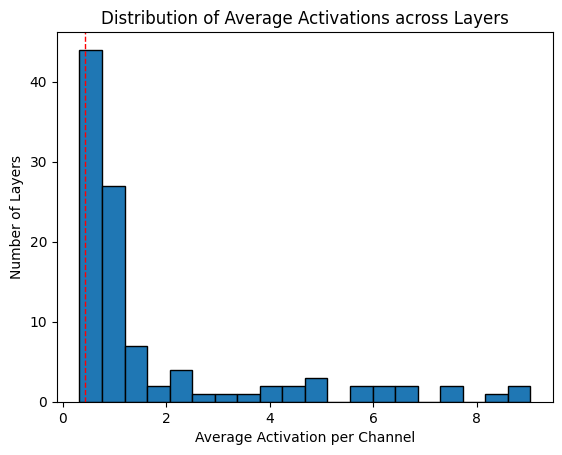

In [29]:
import matplotlib.pyplot as plt

# Collect all average activations across layers
all_avg_activations = [avg for avg in layer_avg_activations.values()]

# Calculate the 20th percentile as the threshold for low activation
low_activation_threshold = np.percentile(all_avg_activations, 20)  # Adjust percentile as needed
print(f"Calculated threshold for low activations (20th percentile): {low_activation_threshold:.4f}")

# Identify layers below this threshold
low_activation_layers = [name for name, avg_act in layer_avg_activations.items() if avg_act < low_activation_threshold]

print("\nLayers with low activations:")
for layer in low_activation_layers:
    print(layer)


# Plot histogram of average activations
plt.hist(all_avg_activations, bins=20, edgecolor='black')
plt.xlabel("Average Activation per Channel")
plt.ylabel("Number of Layers")
plt.title("Distribution of Average Activations across Layers")
plt.axvline(low_activation_threshold, color='red', linestyle='dashed', linewidth=1)
plt.show()
